In [1]:
# Dubbi:
#1 come mai le chiavi di a sembrano random?
#2 come faccio a non fare re-inserimento ?? Ricorda io estraggo d-1 cosi, più uno, più un altro che è quello di arrivo

In [42]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
include("./src/functions.jl")

rand_disorder (generic function with 1 method)

In [43]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.1 # planted infection rate
λi = 0.1 # inferred infection rate

d = 3 # degree (fixed for now) 
T = 4 # discrete time

γp = 0.1 # planted autoinfection probability
γi = 0.1 # inferred autoinfection probability

N = 5000; #population size

# Population dynamics for the messages

In [44]:
# Creation of the population
# we create μ as the set of all the N functions
# μ[k,ti,ck,τi,σk] is the value taken by the
# function μk with arguments ti,ck,τi,σk
# Using OffsetArrays we managed to keep notation 
# coherent with the notes: 

# i=1,...,N, 
# ti=0,...,T+1 
# c = 0,1
# σ=0,1,2

# The same is done for the ν function later
inizialization = ones(N,T+2,2,T+2,3) / (6*(T+2)^2)
μ = OffsetArrays.OffsetArray(inizialization,0,-1,-1,-1,-1);

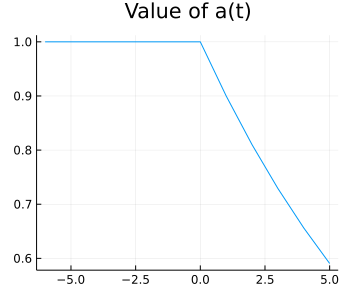

In [45]:
#Precalculation of the function a := (1-λ)^{tθ(t)}, 
#useful for later (the function a appears
#  in the inferred time factor node)

a = Dict(zip(-T-2:T+1,[ t<=0 ? 1 : (1-λi)^t for t = -T-2:T+1]));
μold = copy(μ);
plot(LinRange(-T-2,T+1,2T+4),[a[t] for t=-T-2:T+1],size=(350,300),legend=false,title="Value of a(t)")

In [46]:
ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1);
neighbours = rand(1:N,d-1);

In [67]:
tot_iterations = 20000
@showprogress for iterations = 1:tot_iterations
    # Extraction of disorder: state of individual i: xi0, delays: sij and sji

    xi0,sij,sji = rand_disorder(γp,λp)

    # Initialization of ν=0
    ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    #Extraction of d-1 μ's from population
    neighbours = rand(1:N,d-1)

    #Beginning of calculations: we start by calculating the ν: 
    calculate_ν!(ν,μ,neighbours,xi0,T,γi,a)
    
    # Now we use the ν vector just calculated to extract the new μ.
    # We extract a population index that we call "l".
    # We overwrite the μ in postition μ[l,:,:,:,:]
    l = rand(1:N);

    # First we calculate and store the cumulated of ν with respect to 
    # planted time, i.e. the third argument. We call Σ this cumulated 
    Σ = cumsum(ν,dims=3)
    update_μ!(μ,ν,Σ,l,sij,sji,T)     
end

#p1=plot(reshape(sum(μ,dims=1) ./ N,864))
#p1=plot!(reshape(sum(μold,dims=1) ./ N,864))
#μold = copy(μ);
#plot(p1)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:13


We plot the heatmaps of the messages

# From messages to marginals

In [68]:
p = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2),-1,-1,-1);
marg = OffsetArrays.OffsetArray(zeros(N,T+2,T+2),0,-1,-1);
max_count = N;

In [69]:
# Now we take out converged population of μ and use it to extract marginals.
# First we extract two ν's and then we combine it in order to obtain a marginal.
# In order to extract a ν we have to extract d-1 μ's. Therefore we extract two groups of 
# d-1 μ's and from them we calculate the two ν's. We also have to extract disorder.
@showprogress for l = 1:max_count
    group1 = rand(1:N,d-1) #groups of neighbours 
    group2 = rand(1:N,d-1)
    
    xi0,sij,sji = rand_disorder(γp,λp) #planted disorder
    xj0 = Int(rand() < γp);
    
    ν1 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)
    ν2 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    calculate_ν!(ν1,μ,group1,xi0,T,γi,a)
    calculate_ν!(ν2,μ,group2,xj0,T,γi,a)

    #Once the ν are calculated we have to cumulate with respect the third argument
    Σ = cumsum(ν2,dims=3)
    update_marginal!(marg,l,ν1,ν2,Σ,sij,sji,T)
end
marg2D = reshape((sum(marg,dims=1)./ max_count),T+2,T+2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


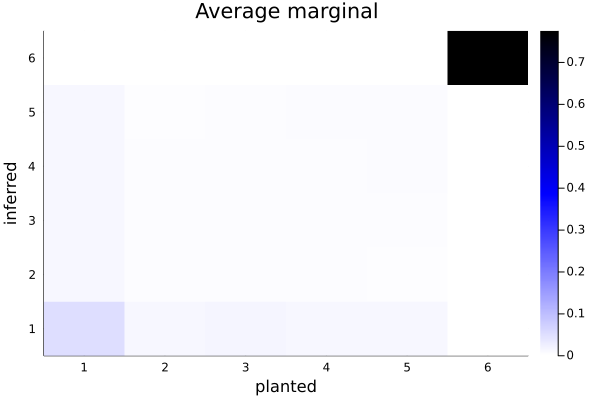

In [70]:
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average marginal")

# Single Instance Inferernce with Sib

## No disorder
In this regime we don't have disorder, in the sense that the planted distribution is a delta. The planted observation is "all infected"

In [249]:
include("./src/BP.jl")

Ngraph = 10 # size of the single instance graph

G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph #the graph

# observations set in the form of 
# [(individual,state,observation time, false_rate of the test)]
# where state ∈ {0,1} respectively for S and I
# The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
# Instead we go from time 0 to time T 
# I am not completely sure that it is correct to put here T+1 and later a T+2. Maybe is more complicated. 
O = [(i,1,T+1,1e-10) for i=1:Ngraph] 

#we now run the BP algorithm for the single instance defined above
p_sib = sibyl(Ngraph, T+2, G, O, γi, λi; maxit = 40, tol = 1e-7);


sib.iterate(damp=0.0): 9/40 6.471e-09/1e-07      
sib.iterate(damp=0.5): 0/40 2.263e-09/1e-07      


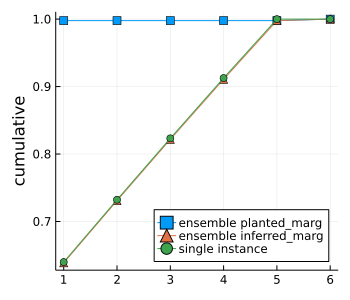

In [250]:
# we plot the marginal distribution and also the ensemble results 

p0 = plot(cumsum(sum(marg2D,dims=1)',dims=1),marker=:square,label="ensemble planted_marg")
p0 = plot!(cumsum(sum(marg2D,dims=2),dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)

p0 = plot!(sum(p_sib,dims=1)'/ Ngraph,marker=:circle,label="single instance")
#p1 = plot!(cumsum(sum(marg2D,dims=2),dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:topleft)
plot(p0,size=(350,300),ylabel="cumulative",)

#savefig("comparison_marg.pdf")

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the sampler vs ensemble planted
Here we check that the sampler ditribution reproduces the planted marginal. So we just study that the forward distributions coincide

In [256]:
include("./src/sampler.jl")
include("./src/BP.jl")

Ngraph = 1000 # size of the single instance graph
x = zeros(Int,Ngraph, T + 2) # a single epidemic trajectory

# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+2)
yBPerr = zero(y) #errorbars
yBP = zero(y)
# we average over totst iterations
totst = 1500
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+2, G, [], γi, λi; maxit = 40, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib,dims=1)' .^ 2
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBP ./= (Ngraph * totst)
yBPerr ./= (Ngraph^2 * totst)
yBPerr .= sqrt.(yerr .- y .^ 2) / sqrt(totst)

y[end] = 1;
# we plot the average marginal

Progress:   2%|▊                                        |  ETA: 0:38:18


sib.iterate(damp=0.0): 5/40 4.235e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.174e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.587e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.584e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.097e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.049e-06/0.01      
sib.iterate(damp=0.0): 5/40 5.804e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.056e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.280e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.806e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.037e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.021e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.437e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.385e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.192e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.978e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.096e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.053e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.919e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.787e-04/0.01      
sib.iterate(damp=0.

Progress:   4%|█▌                                       |  ETA: 0:36:34


sib.iterate(damp=0.0): 4/40 8.368e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.741e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.871e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.793e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.429e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.222e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.932e-04/0.01      
sib.iterate(damp=0.5): 0/40 6.702e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.351e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.577e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.803e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.901e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.457e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.618e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.320e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.402e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.634e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.317e-04/0.01      
sib.iterate(damp=0.0): 4/40 7.273e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.504e-04/0.01      
sib.iterate(damp=0.

Progress:   6%|██▍                                      |  ETA: 0:35:37


sib.iterate(damp=0.0): 4/40 8.951e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.680e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.340e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.168e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.550e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.280e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.849e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.672e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.836e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.222e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.257e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.629e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.573e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.673e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.836e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.982e-04/0.01      
sib.iterate(damp=0.5): 0/40 6.710e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.355e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.758e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.236e-04/0.01      
sib.iterate(damp=0.

Progress:   8%|███▏                                     |  ETA: 0:35:09


sib.iterate(damp=0.0): 5/40 6.821e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.245e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.122e-06/0.01      
sib.iterate(damp=0.0): 5/40 6.051e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.687e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.343e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.243e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.169e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.085e-06/0.01      
sib.iterate(damp=0.0): 5/40 5.500e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.745e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.372e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.835e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.816e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.908e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.342e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.636e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.818e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.673e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.773e-04/0.01      
sib.iterate(damp=0.

Progress:   9%|███▉                                     |  ETA: 0:34:09


sib.iterate(damp=0.0): 4/40 8.139e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.552e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.276e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.282e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.349e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.175e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.804e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.157e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.784e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.373e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.704e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.859e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.278e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.956e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.478e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.607e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.377e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.189e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.372e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.362e-04/0.01      
sib.iterate(damp=0.

Progress:  11%|████▋                                    |  ETA: 0:33:26


sib.iterate(damp=0.0): 4/40 9.474e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.440e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.220e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.542e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.677e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.339e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.014e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.599e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.300e-06/0.01      
sib.iterate(damp=0.0): 5/40 6.444e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.761e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.381e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.830e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.448e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.224e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.618e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.916e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.958e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.126e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.731e-06/0.01      
sib.iterate(damp=0.

Progress:  13%|█████▌                                   |  ETA: 0:32:54


sib.iterate(damp=0.0): 4/40 9.645e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.849e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.925e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.146e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.804e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.902e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.967e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.959e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.980e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.692e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.610e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.305e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.470e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.433e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.717e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.277e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.927e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.479e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.598e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.197e-06/0.01      
sib.iterate(damp=0.

Progress:  15%|██████▎                                  |  ETA: 0:31:54


sib.iterate(damp=0.0): 4/40 9.122e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.852e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.426e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.180e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.294e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.152e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.946e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.745e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.872e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.525e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.777e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.388e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.264e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.147e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.574e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.219e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.282e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.141e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.352e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.614e-04/0.01      
sib.iterate(damp=0.

Progress:  17%|███████                                  |  ETA: 0:31:12


sib.iterate(damp=0.0): 5/40 6.045e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.669e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.335e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.544e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.107e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.533e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.786e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.594e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.297e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.439e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.050e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.251e-06/0.01      
sib.iterate(damp=0.0): 4/40 7.928e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.603e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.302e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.995e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.622e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.311e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.127e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.560e-04/0.01      
sib.iterate(damp=0.

Progress:  19%|███████▉                                 |  ETA: 0:30:27


sib.iterate(damp=0.0): 5/40 4.878e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.672e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.836e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.365e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.788e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.394e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.533e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.521e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.768e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.487e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.249e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.124e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.802e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.572e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.286e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.120e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.632e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.323e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.852e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.699e-04/0.01      
sib.iterate(damp=0.

Progress:  21%|████████▋                                |  ETA: 0:29:31


sib.iterate(damp=0.0): 4/40 8.288e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.074e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.037e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.974e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.958e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.979e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.590e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.803e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.402e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.333e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.559e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.281e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.642e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.491e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.745e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.478e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.691e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.870e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.749e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.346e-04/0.01      
sib.iterate(damp=0.

Progress:  23%|█████████▍                               |  ETA: 0:28:52


sib.iterate(damp=0.0): 4/40 8.879e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.766e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.383e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.449e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.635e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.318e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.949e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.231e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.615e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.155e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.266e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.134e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.097e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.868e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.934e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.553e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.916e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.458e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.245e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.733e-06/0.01      
sib.iterate(damp=0.

Progress:  25%|██████████▎                              |  ETA: 0:28:09


sib.iterate(damp=0.0): 4/40 9.342e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.086e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.043e-04/0.01      
sib.iterate(damp=0.0): 4/40 7.897e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.099e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.055e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.541e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.304e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.652e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.649e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.607e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.304e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.371e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.244e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.122e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.765e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.056e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.545e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.755e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.568e-04/0.01      
sib.iterate(damp=0.

Progress:  27%|███████████                              |  ETA: 0:27:17


sib.iterate(damp=0.0): 4/40 8.736e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.170e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.585e-04/0.01      
sib.iterate(damp=0.0): 4/40 7.969e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.994e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.010e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.549e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.378e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.696e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.403e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.206e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.603e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.202e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.374e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.187e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.619e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.075e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.038e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.465e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.926e-04/0.01      
sib.iterate(damp=0.

Progress:  29%|███████████▊                             |  ETA: 0:26:37


sib.iterate(damp=0.0): 5/40 4.588e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.217e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.608e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.857e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.801e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.901e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.767e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.328e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.166e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.310e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.300e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.150e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.146e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.113e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.557e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.134e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.249e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.125e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.608e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.392e-04/0.01      
sib.iterate(damp=0.

Progress:  31%|████████████▌                            |  ETA: 0:25:30


sib.iterate(damp=0.0): 4/40 9.106e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.546e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.274e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.800e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.367e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.185e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.205e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.440e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.720e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.696e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.107e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.053e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.359e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.687e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.844e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.810e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.555e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.278e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.335e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.919e-04/0.01      
sib.iterate(damp=0.

Progress:  32%|█████████████▎                           |  ETA: 0:24:08


sib.iterate(damp=0.0): 5/40 4.941e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.188e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.594e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.213e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.626e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.813e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.674e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.698e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.349e-06/0.01      
sib.iterate(damp=0.0): 5/40 5.508e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.178e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.089e-06/0.01      
sib.iterate(damp=0.0): 4/40 7.841e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.182e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.603e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.088e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.291e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.646e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.367e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.799e-06/0.01      
sib.iterate(damp=0.

Progress:  34%|██████████████▏                          |  ETA: 0:23:21


sib.iterate(damp=0.0): 4/40 8.412e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.193e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.597e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.445e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.272e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.136e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.070e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.317e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.158e-06/0.01      
sib.iterate(damp=0.0): 5/40 5.181e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.186e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.593e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.952e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.835e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.418e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.304e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.288e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.644e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.558e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.219e-06/0.01      
sib.iterate(damp=0.

Progress:  36%|██████████████▉                          |  ETA: 0:22:40


sib.iterate(damp=0.0): 4/40 9.213e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.450e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.225e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.178e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.962e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.988e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.653e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.238e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.119e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.352e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.671e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.835e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.620e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.660e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.330e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.671e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.510e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.256e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.446e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.240e-06/0.01      
sib.iterate(damp=0.

Progress:  38%|███████████████▋                         |  ETA: 0:22:04


sib.iterate(damp=0.0): 5/40 5.751e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.118e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.559e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.243e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.048e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.240e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.511e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.796e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.398e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.536e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.127e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.563e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.834e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.008e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.007e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.970e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.119e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.560e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.781e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.053e-06/0.01      
sib.iterate(damp=0.

Progress:  40%|████████████████▌                        |  ETA: 0:21:22


sib.iterate(damp=0.0): 4/40 9.387e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.910e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.455e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.590e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.273e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.137e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.349e-04/0.01      
sib.iterate(damp=0.5): 0/40 6.812e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.406e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.714e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.361e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.180e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.183e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.434e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.225e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.400e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.953e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.976e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.675e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.724e-06/0.01      
sib.iterate(damp=0.

Progress:  42%|█████████████████▎                       |  ETA: 0:20:41


sib.iterate(damp=0.0): 4/40 8.959e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.386e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.693e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.542e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.004e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.002e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.409e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.039e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.029e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.067e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.991e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.995e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.444e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.024e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.012e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.770e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.964e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.487e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.770e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.332e-04/0.01      
sib.iterate(damp=0.

Progress:  44%|██████████████████                       |  ETA: 0:20:01


sib.iterate(damp=0.0): 4/40 8.678e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.611e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.806e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.173e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.164e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.082e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.347e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.542e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.271e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.481e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.271e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.636e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.512e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.313e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.162e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.551e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.610e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.305e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.641e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.630e-06/0.01      
sib.iterate(damp=0.

Progress:  46%|██████████████████▊                      |  ETA: 0:19:01


sib.iterate(damp=0.0): 4/40 9.744e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.467e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.234e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.204e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.682e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.857e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.443e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.780e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.395e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.000e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.198e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.099e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.495e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.829e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.415e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.621e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.928e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.464e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.258e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.218e-04/0.01      
sib.iterate(damp=0.

Progress:  48%|███████████████████▋                     |  ETA: 0:18:09


sib.iterate(damp=0.0): 4/40 9.777e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.245e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.633e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.812e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.984e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.492e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.376e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.193e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.963e-06/0.01      
sib.iterate(damp=0.0): 5/40 5.144e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.611e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.805e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.664e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.342e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.171e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.949e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.258e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.129e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.746e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.098e-05/0.01      
sib.iterate(damp=0.

Progress:  50%|████████████████████▍                    |  ETA: 0:17:30


sib.iterate(damp=0.0): 4/40 9.844e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.552e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.283e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.708e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.235e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.134e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.560e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.742e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.371e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.435e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.056e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.282e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.062e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.238e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.119e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.152e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.803e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.402e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.043e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.730e-04/0.01      
sib.iterate(damp=0.

Progress:  52%|█████████████████████▏                   |  ETA: 0:16:51


sib.iterate(damp=0.0): 5/40 4.826e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.260e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.130e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.290e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.014e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.512e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.817e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.967e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.484e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.700e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.049e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.027e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.800e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.188e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.594e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.586e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.484e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.742e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.118e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.821e-04/0.01      
sib.iterate(damp=0.

Progress:  54%|██████████████████████                   |  ETA: 0:16:12


sib.iterate(damp=0.0): 5/40 4.644e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.625e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.812e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.313e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.384e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.692e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.038e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.781e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.893e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.072e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.308e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.154e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.104e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.924e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.462e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.273e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.213e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.606e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.447e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.330e-04/0.01      
sib.iterate(damp=0.

Progress:  55%|██████████████████████▊                  |  ETA: 0:15:34


sib.iterate(damp=0.0): 5/40 4.542e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.016e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.078e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.717e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.531e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.275e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.577e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.054e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.272e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.844e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.930e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.976e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.966e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.250e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.125e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.235e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.314e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.157e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.946e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.626e-04/0.01      
sib.iterate(damp=0.

Progress:  57%|███████████████████████▌                 |  ETA: 0:14:58


sib.iterate(damp=0.0): 5/40 3.447e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.203e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.601e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.653e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.989e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.002e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.625e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.662e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.331e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.008e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.982e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.991e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.778e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.139e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.070e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.427e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.080e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.040e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.722e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.798e-04/0.01      
sib.iterate(damp=0.

Progress:  59%|████████████████████████▎                |  ETA: 0:14:19


sib.iterate(damp=0.0): 4/40 9.686e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.188e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.099e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.822e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.344e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.172e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.767e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.081e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.541e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.866e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.295e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.148e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.522e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.595e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.298e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.734e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.878e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.509e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.682e-04/0.01      
sib.iterate(damp=0.

Progress:  61%|█████████████████████████▏               |  ETA: 0:13:39


sib.iterate(damp=0.0): 5/40 4.234e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.619e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.810e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.902e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.849e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.432e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.000e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.943e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.471e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.114e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.258e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.129e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.504e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.493e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.752e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.238e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.043e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.021e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.531e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.808e-04/0.01      
sib.iterate(damp=0.

Progress:  63%|█████████████████████████▉               |  ETA: 0:12:59


sib.iterate(damp=0.0): 4/40 8.876e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.481e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.749e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.600e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.068e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.039e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.246e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.189e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.094e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.427e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.990e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.000e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.026e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.376e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.202e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.707e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.459e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.229e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.255e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.621e-04/0.01      
sib.iterate(damp=0.

Progress:  65%|██████████████████████████▋              |  ETA: 0:12:20


sib.iterate(damp=0.0): 4/40 9.842e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.686e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.843e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.532e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.151e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.580e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.150e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.162e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.591e-04/0.01      
sib.iterate(damp=0.0): 4/40 7.977e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.377e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.197e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.228e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.470e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.735e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.492e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.138e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.071e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.471e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.550e-04/0.01      
sib.iterate(damp=0.

Progress:  67%|███████████████████████████▌             |  ETA: 0:11:42


sib.iterate(damp=0.0): 4/40 8.662e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.971e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.986e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.506e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.207e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.104e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.949e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.890e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.445e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.576e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.761e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.391e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.836e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.511e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.256e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.809e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.943e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.475e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.468e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.711e-06/0.01      
sib.iterate(damp=0.

Progress:  69%|████████████████████████████▎            |  ETA: 0:11:01


sib.iterate(damp=0.0): 4/40 8.316e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.733e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.866e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.821e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.517e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.258e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.464e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.681e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.341e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.072e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.377e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.689e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.775e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.961e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.981e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.031e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.385e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.192e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.531e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.558e-04/0.01      
sib.iterate(damp=0.

Progress:  71%|█████████████████████████████            |  ETA: 0:10:20


sib.iterate(damp=0.0): 4/40 8.226e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.360e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.180e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.678e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.401e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.201e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.875e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.374e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.687e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.568e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.828e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.414e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.871e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.416e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.708e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.445e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.325e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.663e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.519e-04/0.01      
sib.iterate(damp=0.5): 0/40 6.767e-06/0.01      
sib.iterate(damp=0.

Progress:  73%|█████████████████████████████▉           |  ETA: 0:09:40


sib.iterate(damp=0.0): 4/40 9.514e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.158e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.079e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.321e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.562e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.281e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.317e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.295e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.648e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.733e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.743e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.871e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.314e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.541e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.770e-06/0.01      
sib.iterate(damp=0.0): 5/40 5.014e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.313e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.156e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.374e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.112e-04/0.01      
sib.iterate(damp=0.

Progress:  75%|██████████████████████████████▋          |  ETA: 0:09:00


sib.iterate(damp=0.0): 5/40 4.328e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.622e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.311e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.493e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.445e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.722e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.159e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.185e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.593e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.648e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.945e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.972e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.155e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.244e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.622e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.817e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.697e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.856e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.321e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.652e-06/0.01      
sib.iterate(damp=0.

Progress:  77%|███████████████████████████████▍         |  ETA: 0:08:20


sib.iterate(damp=0.0): 4/40 9.113e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.508e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.754e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.347e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.852e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.426e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.620e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.622e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.811e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.225e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.201e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.600e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.450e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.647e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.334e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.831e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.375e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.187e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.837e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.767e-04/0.01      
sib.iterate(damp=0.

Progress:  79%|████████████████████████████████▎        |  ETA: 0:07:39


sib.iterate(damp=0.0): 4/40 9.571e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.565e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.283e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.440e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.753e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.877e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.599e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.923e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.961e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.485e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.263e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.132e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.918e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.683e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.842e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.249e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.688e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.844e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.100e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.733e-04/0.01      
sib.iterate(damp=0.

Progress:  81%|█████████████████████████████████        |  ETA: 0:06:58


sib.iterate(damp=0.0): 4/40 8.447e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.369e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.184e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.703e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.300e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.150e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.279e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.683e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.347e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.485e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.846e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.923e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.713e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.488e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.747e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.052e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.374e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.203e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.811e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.510e-04/0.01      
sib.iterate(damp=0.

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:06:17


sib.iterate(damp=0.0): 4/40 9.393e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.559e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.281e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.680e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.575e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.288e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.045e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.506e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.753e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.199e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.277e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.139e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.950e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.102e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.508e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.628e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.469e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.234e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.305e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.149e-06/0.01      
sib.iterate(damp=0.

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:05:37


sib.iterate(damp=0.0): 4/40 8.735e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.568e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.284e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.211e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.024e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.119e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.615e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.117e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.559e-06/0.01      
sib.iterate(damp=0.0): 5/40 7.162e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.589e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.294e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.375e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.346e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.178e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.460e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.646e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.823e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.923e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.728e-04/0.01      
sib.iterate(damp=0.

Progress:  86%|███████████████████████████████████▍     |  ETA: 0:04:57


sib.iterate(damp=0.0): 4/40 8.935e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.879e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.939e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.621e-04/0.01      
sib.iterate(damp=0.5): 0/40 6.788e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.394e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.045e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.632e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.316e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.678e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.494e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.747e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.387e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.776e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.888e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.163e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.499e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.250e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.233e-04/0.01      
sib.iterate(damp=0.5): 0/40 6.722e-06/0.01      
sib.iterate(damp=0.

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:04:17


sib.iterate(damp=0.0): 5/40 5.139e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.660e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.330e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.658e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.459e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.730e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.255e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.089e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.045e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.586e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.763e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.382e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.660e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.166e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.083e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.437e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.103e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.552e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.432e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.969e-04/0.01      
sib.iterate(damp=0.

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:03:35


sib.iterate(damp=0.0): 4/40 8.178e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.365e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.182e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.734e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.828e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.915e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.395e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.538e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.269e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.134e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.675e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.342e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.513e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.141e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.572e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.650e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.753e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.377e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.662e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.649e-04/0.01      
sib.iterate(damp=0.

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:02:54


sib.iterate(damp=0.0): 4/40 9.098e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.814e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.407e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.786e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.290e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.146e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.571e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.968e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.484e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.662e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.051e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.025e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.986e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.465e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.744e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.425e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.516e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.267e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.616e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.080e-04/0.01      
sib.iterate(damp=0.

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:02:12


sib.iterate(damp=0.0): 5/40 4.293e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.693e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.346e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.537e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.061e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.030e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.845e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.268e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.137e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.084e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.406e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.203e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.903e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.668e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.834e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.921e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.505e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.260e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.879e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.732e-06/0.01      
sib.iterate(damp=0.

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:01:31


sib.iterate(damp=0.0): 4/40 8.014e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.966e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.983e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.779e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.037e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.019e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.830e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.774e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.893e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.557e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.240e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.620e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.635e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.235e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.118e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.035e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.628e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.314e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.200e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.492e-04/0.01      
sib.iterate(damp=0.

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:49


sib.iterate(damp=0.0): 4/40 9.979e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.384e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.192e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.509e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.687e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.848e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.321e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.647e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.842e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.826e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.333e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.166e-06/0.01      
sib.iterate(damp=0.0): 5/40 3.712e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.164e-06/0.01      
sib.iterate(damp=0.9): 0/40 4.582e-06/0.01      
sib.iterate(damp=0.0): 5/40 4.881e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.807e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.903e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.889e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.989e-04/0.01      
sib.iterate(damp=0.

Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:07


sib.iterate(damp=0.0): 4/40 8.139e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.665e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.333e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.900e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.600e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.800e-06/0.01      
sib.iterate(damp=0.0): 4/40 8.981e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.600e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.300e-04/0.01      
sib.iterate(damp=0.0): 4/40 9.542e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.911e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.957e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.884e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.022e-05/0.01      
sib.iterate(damp=0.9): 0/40 5.111e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.438e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.797e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.406e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.053e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.153e-04/0.01      
sib.iterate(damp=0.

Progress: 100%|█████████████████████████████████████████| Time: 0:35:58



sib.iterate(damp=0.0): 4/40 7.988e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.644e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.322e-04/0.01      
sib.iterate(damp=0.0): 4/40 7.437e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.747e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.873e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.538e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.296e-06/0.01      
sib.iterate(damp=0.9): 0/40 3.648e-06/0.01      
sib.iterate(damp=0.0): 4/40 9.361e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.372e-04/0.01      


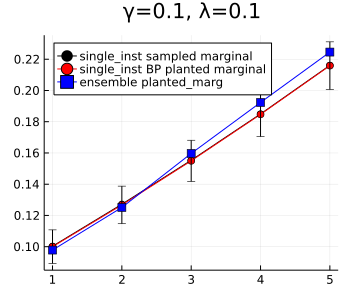

In [257]:
p0 = plot(y[1:end-1],c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBP[1:end-1],c=:red,yerr=yBPerr,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)

### Comparison between inference (sibyl) and ensemble results

In [258]:
yBP = zeros(T+2)
yBPerr = zero(yinf)
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,x[i,T],T+1,1e-10) for i = 1:Ngraph]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+2, G, O, γi, λi; maxit = 40, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib .^ 2,dims=1)' 
end

yBP ./= (Ngraph * totst)
yBPerr ./= (Ngraph * totst)
yinferr .= sqrt.(yBPerr .- yBP .^ 2) / sqrt(totst)


Progress:   2%|▋                                        |  ETA: 0:39:58


sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.606e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.460e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.852e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.697e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.348e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.357e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.692e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.846e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.092e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.267e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.335e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.384e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.267e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.335e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.846e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.713e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.564e-04/0.01      
sib.iterate(damp=0.0): 5/40 1.285e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.915e-12/0.01      
sib.iterate(damp=0.

Progress:   3%|█▍                                       |  ETA: 0:37:54


sib.iterate(damp=0.0): 5/40 6.595e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.213e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.064e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.239e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.563e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.782e-03/0.01      
sib.iterate(damp=0.0): 6/40 1.003e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.922e-05/0.01      
sib.iterate(damp=0.9): 0/40 2.461e-05/0.01      
sib.iterate(damp=0.0): 6/40 3.786e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.152e-05/0.01      
sib.iterate(damp=0.9): 0/40 4.576e-05/0.01      
sib.iterate(damp=0.0): 6/40 4.772e-04/0.01      
sib.iterate(damp=0.5): 0/40 2.637e-12/0.01      
sib.iterate(damp=0.9): 0/40 1.307e-12/0.01      
sib.iterate(damp=0.0): 5/40 7.346e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.861e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.930e-03/0.01      
sib.iterate(damp=0.0): 5/40 1.023e-11/0.01      
sib.iterate(damp=0.5): 0/40 5.464e-12/0.01      
sib.iterate(damp=0.

Progress:   5%|██                                       |  ETA: 0:37:18


sib.iterate(damp=0.0): 5/40 5.765e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.239e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.120e-03/0.01      
sib.iterate(damp=0.0): 6/40 1.286e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.615e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.807e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.036e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.401e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.200e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.590e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.265e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.632e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.010e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.750e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.375e-03/0.01      
sib.iterate(damp=0.0): 6/40 9.602e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.200e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.204e-04/0.01      
sib.iterate(damp=0.0): 6/40 4.984e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.126e-03/0.01      
sib.iterate(damp=0.

Progress:   7%|██▊                                      |  ETA: 0:36:40


sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.384e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.918e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.245e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.163e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.082e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.595e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.975e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.487e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.393e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.251e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.555e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.777e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.340e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.142e-12/0.01      
sib.iterate(damp=0.9): 0/40 1.577e-12/0.01      
sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.635e-03/0.01      
sib.iterate(damp=0.

Progress:   8%|███▌                                     |  ETA: 0:36:08


sib.iterate(damp=0.0): 5/40 8.657e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.564e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.282e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.032e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.829e-03/0.01      
sib.iterate(damp=0.9): 0/40 9.144e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.524e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.826e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.413e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.018e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.851e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.425e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.172e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.492e-03/0.01      
sib.iterate(damp=0.9): 0/40 7.459e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.431e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.683e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.341e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.595e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.067e-03/0.01      
sib.iterate(damp=0.

Progress:  10%|████▏                                    |  ETA: 0:35:07


sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.021e-03/0.01      
sib.iterate(damp=0.9): 0/40 4.669e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.118e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.925e-03/0.01      
sib.iterate(damp=0.9): 0/40 9.624e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.648e-12/0.01      
sib.iterate(damp=0.9): 0/40 4.824e-12/0.01      
sib.iterate(damp=0.0): 5/40 6.835e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.518e-03/0.01      
sib.iterate(damp=0.9): 0/40 7.615e-04/0.01      
sib.iterate(damp=0.0): 6/40 4.340e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.525e-12/0.01      
sib.iterate(damp=0.9): 0/40 7.627e-13/0.01      
sib.iterate(damp=0.0): 5/40 7.695e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.544e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.772e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.599e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.710e-03/0.01      
sib.iterate(damp=0.

Progress:  12%|████▊                                    |  ETA: 0:34:20


sib.iterate(damp=0.0): 5/40 4.984e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.867e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.933e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.763e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.357e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.179e-03/0.01      
sib.iterate(damp=0.0): 6/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.291e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.146e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.539e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.164e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.083e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.606e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.477e-03/0.01      
sib.iterate(damp=0.9): 0/40 7.383e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.231e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.771e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.885e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.671e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.512e-03/0.01      
sib.iterate(damp=0.

Progress:  13%|█████▌                                   |  ETA: 0:33:34


sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.148e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.074e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.446e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.279e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.140e-03/0.01      
sib.iterate(damp=0.0): 6/40 2.472e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.954e-04/0.01      
sib.iterate(damp=0.9): 0/40 9.768e-05/0.01      
sib.iterate(damp=0.0): 6/40 3.572e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.022e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.108e-04/0.01      
sib.iterate(damp=0.0): 5/40 2.472e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.663e-12/0.01      
sib.iterate(damp=0.9): 0/40 3.332e-12/0.01      
sib.iterate(damp=0.0): 5/40 8.320e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.229e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.146e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.267e-03/0.01      
sib.iterate(damp=0.

Progress:  15%|██████▏                                  |  ETA: 0:32:51


sib.iterate(damp=0.0): 6/40 4.367e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.518e-04/0.01      
sib.iterate(damp=0.9): 0/40 7.591e-05/0.01      
sib.iterate(damp=0.0): 6/40 1.267e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.222e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.111e-04/0.01      
sib.iterate(damp=0.0): 6/40 8.119e-04/0.01      
sib.iterate(damp=0.5): 0/40 4.613e-05/0.01      
sib.iterate(damp=0.9): 0/40 2.190e-05/0.01      
sib.iterate(damp=0.0): 6/40 1.873e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.286e-04/0.01      
sib.iterate(damp=0.9): 0/40 6.429e-05/0.01      
sib.iterate(damp=0.0): 6/40 3.943e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.572e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.786e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.034e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.170e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.932e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.333e-03/0.01      
sib.iterate(damp=0.

Progress:  17%|██████▉                                  |  ETA: 0:32:15


sib.iterate(damp=0.0): 6/40 1.816e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.709e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.354e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.218e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.092e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.284e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.351e-05/0.01      
sib.iterate(damp=0.9): 0/40 3.676e-05/0.01      
sib.iterate(damp=0.0): 5/40 6.753e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.984e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.492e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.719e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.827e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.913e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.963e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.453e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.226e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.179e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.590e-04/0.01      
sib.iterate(damp=0.

Progress:  18%|███████▌                                 |  ETA: 0:31:28


sib.iterate(damp=0.0): 5/40 1.280e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.251e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.625e-04/0.01      
sib.iterate(damp=0.0): 6/40 5.795e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.561e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.281e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.340e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.300e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.150e-04/0.01      
sib.iterate(damp=0.0): 6/40 5.228e-04/0.01      
sib.iterate(damp=0.5): 0/40 5.858e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.929e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.737e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.258e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.629e-03/0.01      
sib.iterate(damp=0.0): 6/40 1.384e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.476e-12/0.01      
sib.iterate(damp=0.9): 0/40 1.739e-12/0.01      
sib.iterate(damp=0.0): 6/40 3.526e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.230e-04/0.01      
sib.iterate(damp=0.

Progress:  20%|████████▎                                |  ETA: 0:30:56


sib.iterate(damp=0.0): 5/40 4.648e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.941e-03/0.01      
sib.iterate(damp=0.9): 0/40 9.703e-04/0.01      
sib.iterate(damp=0.0): 6/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.251e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.256e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.712e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.126e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.063e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.135e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.278e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.139e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.599e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.340e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.170e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.459e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.075e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.377e-04/0.01      
sib.iterate(damp=0.0): 6/40 3.470e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.306e-03/0.01      
sib.iterate(damp=0.

Progress:  22%|█████████                                |  ETA: 0:30:17


sib.iterate(damp=0.0): 6/40 5.650e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.690e-13/0.01      
sib.iterate(damp=0.9): 0/40 3.846e-13/0.01      
sib.iterate(damp=0.0): 5/40 3.749e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.616e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.078e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.524e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.882e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.441e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.517e-11/0.01      
sib.iterate(damp=0.5): 0/40 3.624e-11/0.01      
sib.iterate(damp=0.9): 0/40 1.812e-11/0.01      
sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.698e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.340e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.984e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.492e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.370e-03/0.01      
sib.iterate(damp=0.

Progress:  23%|█████████▋                               |  ETA: 0:29:33


sib.iterate(damp=0.0): 5/40 8.864e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.045e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.227e-04/0.01      
sib.iterate(damp=0.0): 5/40 2.126e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.958e-05/0.01      
sib.iterate(damp=0.9): 0/40 3.979e-05/0.01      
sib.iterate(damp=0.0): 5/40 6.818e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.489e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.245e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.043e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.086e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.043e-03/0.01      
sib.iterate(damp=0.0): 5/40 3.943e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.929e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.965e-04/0.01      
sib.iterate(damp=0.0): 6/40 7.048e-12/0.01      
sib.iterate(damp=0.5): 0/40 1.523e-12/0.01      
sib.iterate(damp=0.9): 0/40 7.614e-13/0.01      
sib.iterate(damp=0.0): 5/40 2.800e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.908e-04/0.01      
sib.iterate(damp=0.

Progress:  25%|██████████▍                              |  ETA: 0:28:50


sib.iterate(damp=0.0): 5/40 5.579e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.126e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.063e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.423e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.712e-03/0.01      
sib.iterate(damp=0.0): 6/40 3.479e-04/0.01      
sib.iterate(damp=0.5): 0/40 2.777e-13/0.01      
sib.iterate(damp=0.9): 0/40 1.388e-13/0.01      
sib.iterate(damp=0.0): 5/40 8.589e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.753e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.877e-03/0.01      
sib.iterate(damp=0.0): 5/40 3.523e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.637e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.318e-03/0.01      
sib.iterate(damp=0.0): 5/40 2.498e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.266e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.133e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.782e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.770e-03/0.01      
sib.iterate(damp=0.

Progress:  27%|███████████                              |  ETA: 0:28:11


sib.iterate(damp=0.0): 5/40 7.346e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.070e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.535e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.340e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.519e-05/0.01      
sib.iterate(damp=0.9): 0/40 4.259e-05/0.01      
sib.iterate(damp=0.0): 5/40 7.071e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.992e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.996e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.599e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.340e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.170e-03/0.01      
sib.iterate(damp=0.0): 6/40 2.800e-12/0.01      
sib.iterate(damp=0.5): 0/40 1.789e-13/0.01      
sib.iterate(damp=0.9): 0/40 8.937e-14/0.01      
sib.iterate(damp=0.0): 6/40 1.743e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.867e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.933e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.048e-04/0.01      
sib.iterate(damp=0.5): 0/40 4.139e-12/0.01      
sib.iterate(damp=0.

Progress:  29%|███████████▊                             |  ETA: 0:27:39


sib.iterate(damp=0.0): 6/40 3.417e-12/0.01      
sib.iterate(damp=0.5): 0/40 7.334e-13/0.01      
sib.iterate(damp=0.9): 0/40 3.669e-13/0.01      
sib.iterate(damp=0.0): 5/40 7.344e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.958e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.479e-03/0.01      
sib.iterate(damp=0.0): 6/40 6.957e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.955e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.977e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.328e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.485e-05/0.01      
sib.iterate(damp=0.9): 0/40 7.425e-06/0.01      
sib.iterate(damp=0.0): 5/40 6.301e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.795e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.974e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.604e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.085e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.542e-03/0.01      
sib.iterate(damp=0.0): 6/40 2.344e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.495e-13/0.01      
sib.iterate(damp=0.

Progress:  30%|████████████▍                            |  ETA: 0:26:46


sib.iterate(damp=0.0): 6/40 2.398e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.587e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.793e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.547e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.844e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.422e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.416e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.809e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.405e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.065e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.465e-12/0.01      
sib.iterate(damp=0.9): 0/40 2.732e-12/0.01      
sib.iterate(damp=0.0): 5/40 7.469e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.362e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.809e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.192e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.165e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.082e-03/0.01      
sib.iterate(damp=0.0): 6/40 3.829e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.645e-04/0.01      
sib.iterate(damp=0.

Progress:  32%|█████████████▏                           |  ETA: 0:25:27


sib.iterate(damp=0.0): 6/40 1.750e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.659e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.321e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.979e-04/0.01      
sib.iterate(damp=0.5): 0/40 5.492e-05/0.01      
sib.iterate(damp=0.9): 0/40 2.746e-05/0.01      
sib.iterate(damp=0.0): 5/40 7.150e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.372e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.686e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.838e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.383e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.191e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.625e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.169e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.585e-04/0.01      
sib.iterate(damp=0.0): 6/40 4.340e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.177e-12/0.01      
sib.iterate(damp=0.9): 0/40 5.881e-13/0.01      
sib.iterate(damp=0.0): 6/40 2.050e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.933e-04/0.01      
sib.iterate(damp=0.

Progress:  34%|█████████████▊                           |  ETA: 0:24:36


sib.iterate(damp=0.0): 5/40 8.551e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.266e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.133e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.008e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.487e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.243e-03/0.01      
sib.iterate(damp=0.0): 6/40 1.920e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.390e-13/0.01      
sib.iterate(damp=0.9): 0/40 1.198e-13/0.01      
sib.iterate(damp=0.0): 5/40 5.258e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.384e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.918e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.984e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.126e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.063e-03/0.01      
sib.iterate(damp=0.0): 6/40 9.732e-04/0.01      
sib.iterate(damp=0.5): 0/40 2.404e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.202e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.175e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.100e-05/0.01      
sib.iterate(damp=0.

Progress:  35%|██████████████▍                          |  ETA: 0:24:05


sib.iterate(damp=0.0): 6/40 1.895e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.077e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.538e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.466e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.207e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.604e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.698e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.872e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.619e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.309e-04/0.01      
sib.iterate(damp=0.0): 6/40 5.328e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.702e-05/0.01      
sib.iterate(damp=0.9): 0/40 3.351e-05/0.01      
sib.iterate(damp=0.0): 6/40 6.642e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.607e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.787e-04/0.01      
sib.iterate(damp=0.0): 6/40 3.273e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.727e-04/0.01      
sib.iterate(damp=0.

Progress:  37%|███████████████▏                         |  ETA: 0:23:31


sib.iterate(damp=0.0): 6/40 2.268e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.140e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.700e-05/0.01      
sib.iterate(damp=0.0): 5/40 2.307e-11/0.01      
sib.iterate(damp=0.5): 0/40 7.712e-12/0.01      
sib.iterate(damp=0.9): 0/40 3.856e-12/0.01      
sib.iterate(damp=0.0): 6/40 5.650e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.525e-05/0.01      
sib.iterate(damp=0.9): 0/40 2.763e-05/0.01      
sib.iterate(damp=0.0): 5/40 4.752e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.192e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.596e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.788e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.181e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.091e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.629e-12/0.01      
sib.iterate(damp=0.5): 0/40 5.919e-12/0.01      
sib.iterate(damp=0.9): 0/40 2.963e-12/0.01      
sib.iterate(damp=0.0): 5/40 1.463e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.563e-04/0.01      
sib.iterate(damp=0.

Progress:  39%|███████████████▊                         |  ETA: 0:23:02


sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.941e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.470e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.347e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.257e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.628e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.431e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.060e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.302e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.557e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.678e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.339e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.442e-03/0.01      
sib.iterate(damp=0.9): 0/40 7.210e-04/0.01      
sib.iterate(damp=0.0): 6/40 9.601e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.198e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.599e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.312e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.363e-04/0.01      
sib.iterate(damp=0.

Progress:  40%|████████████████▌                        |  ETA: 0:22:27


sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.648e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.205e-04/0.01      
sib.iterate(damp=0.0): 6/40 7.318e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.681e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.841e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.524e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.757e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.879e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.581e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.709e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.545e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.122e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.061e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.873e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.308e-03/0.01      
sib.iterate(damp=0.9): 0/40 4.654e-03/0.01      
sib.iterate(damp=0.0): 5/40 1.067e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.253e-04/0.01      
sib.iterate(damp=0.

Progress:  42%|█████████████████▏                       |  ETA: 0:21:52


sib.iterate(damp=0.0): 5/40 7.431e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.776e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.882e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.508e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.902e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.451e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.778e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.867e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.433e-03/0.01      
sib.iterate(damp=0.0): 5/40 3.970e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.304e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.652e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.782e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.770e-03/0.01      
sib.iterate(damp=0.9): 0/40 4.385e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.706e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.659e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.830e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.266e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.056e-05/0.01      
sib.iterate(damp=0.

Progress:  44%|█████████████████▉                       |  ETA: 0:21:03


sib.iterate(damp=0.0): 6/40 5.258e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.389e-13/0.01      
sib.iterate(damp=0.9): 0/40 2.196e-13/0.01      
sib.iterate(damp=0.0): 6/40 8.766e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.876e-05/0.01      
sib.iterate(damp=0.9): 0/40 4.938e-05/0.01      
sib.iterate(damp=0.0): 6/40 3.000e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.187e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.594e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.580e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.210e-12/0.01      
sib.iterate(damp=0.9): 0/40 1.605e-12/0.01      
sib.iterate(damp=0.0): 5/40 8.212e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.863e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.431e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.041e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.472e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.236e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.453e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.213e-05/0.01      
sib.iterate(damp=0.

Progress:  45%|██████████████████▌                      |  ETA: 0:20:04


sib.iterate(damp=0.0): 5/40 6.115e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.981e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.991e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.166e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.037e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.019e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.984e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.589e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.795e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.225e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.190e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.095e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.636e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.132e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.066e-03/0.01      
sib.iterate(damp=0.0): 6/40 3.192e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.750e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.893e-04/0.01      
sib.iterate(damp=0.0): 6/40 5.829e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.469e-05/0.01      
sib.iterate(damp=0.

Progress:  47%|███████████████████▎                     |  ETA: 0:19:23


sib.iterate(damp=0.0): 6/40 7.711e-04/0.01      
sib.iterate(damp=0.5): 0/40 4.230e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.115e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.561e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.452e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.726e-03/0.01      
sib.iterate(damp=0.0): 6/40 9.248e-04/0.01      
sib.iterate(damp=0.5): 0/40 4.662e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.333e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.449e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.251e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.001e-04/0.01      
sib.iterate(damp=0.0): 6/40 8.837e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.327e-13/0.01      
sib.iterate(damp=0.9): 0/40 6.661e-14/0.01      
sib.iterate(damp=0.0): 5/40 6.929e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.308e-03/0.01      
sib.iterate(damp=0.9): 0/40 4.654e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.595e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.985e-04/0.01      
sib.iterate(damp=0.

Progress:  49%|███████████████████▉                     |  ETA: 0:18:46


sib.iterate(damp=0.0): 6/40 1.078e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.497e-13/0.01      
sib.iterate(damp=0.9): 0/40 1.248e-13/0.01      
sib.iterate(damp=0.0): 5/40 6.239e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.984e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.492e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.599e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.340e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.170e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.080e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.800e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.998e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.060e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.116e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.582e-04/0.01      
sib.iterate(damp=0.0): 6/40 8.889e-04/0.01      
sib.iterate(damp=0.5): 0/40 7.211e-13/0.01      
sib.iterate(damp=0.9): 0/40 3.599e-13/0.01      
sib.iterate(damp=0.0): 5/40 6.477e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.075e-03/0.01      
sib.iterate(damp=0.

Progress:  50%|████████████████████▋                    |  ETA: 0:18:11


sib.iterate(damp=0.0): 5/40 6.165e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.600e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.000e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.587e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.400e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.998e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.239e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.596e-04/0.01      
sib.iterate(damp=0.9): 0/40 7.981e-05/0.01      
sib.iterate(damp=0.0): 6/40 1.920e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.071e-12/0.01      
sib.iterate(damp=0.9): 0/40 5.348e-13/0.01      
sib.iterate(damp=0.0): 5/40 4.364e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.115e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.575e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.833e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.928e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.464e-03/0.01      
sib.iterate(damp=0.0): 6/40 2.654e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.700e-04/0.01      
sib.iterate(damp=0.

Progress:  52%|█████████████████████▎                   |  ETA: 0:17:38


sib.iterate(damp=0.0): 6/40 2.612e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.904e-04/0.01      
sib.iterate(damp=0.9): 0/40 9.519e-05/0.01      
sib.iterate(damp=0.0): 5/40 4.955e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.239e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.120e-03/0.01      
sib.iterate(damp=0.0): 6/40 9.806e-04/0.01      
sib.iterate(damp=0.5): 0/40 4.892e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.446e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.980e-12/0.01      
sib.iterate(damp=0.5): 0/40 7.548e-13/0.01      
sib.iterate(damp=0.9): 0/40 3.775e-13/0.01      
sib.iterate(damp=0.0): 5/40 9.108e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.126e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.063e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.085e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.216e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.608e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.474e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.317e-03/0.01      
sib.iterate(damp=0.

Progress:  54%|██████████████████████                   |  ETA: 0:17:03


sib.iterate(damp=0.0): 5/40 3.022e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.313e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.156e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.452e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.070e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.350e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.333e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.702e-05/0.01      
sib.iterate(damp=0.9): 0/40 4.351e-05/0.01      
sib.iterate(damp=0.0): 5/40 5.905e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.031e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.016e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.041e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.450e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.725e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.123e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.236e-12/0.01      
sib.iterate(damp=0.9): 0/40 3.618e-12/0.01      
sib.iterate(damp=0.0): 6/40 4.278e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.646e-05/0.01      
sib.iterate(damp=0.

Progress:  55%|██████████████████████▋                  |  ETA: 0:16:31


sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.977e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.488e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.239e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.920e-03/0.01      
sib.iterate(damp=0.9): 0/40 9.599e-04/0.01      
sib.iterate(damp=0.0): 5/40 3.113e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.670e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.835e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.369e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.846e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.864e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.590e-05/0.01      
sib.iterate(damp=0.9): 0/40 4.915e-05/0.01      
sib.iterate(damp=0.0): 5/40 9.426e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.121e-11/0.01      
sib.iterate(damp=0.9): 0/40 5.604e-12/0.01      
sib.iterate(damp=0.0): 6/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.145e-04/0.01      
sib.iterate(damp=0.

Progress:  57%|███████████████████████▍                 |  ETA: 0:15:53


sib.iterate(damp=0.0): 5/40 3.584e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.346e-04/0.01      
sib.iterate(damp=0.9): 0/40 6.729e-05/0.01      
sib.iterate(damp=0.0): 5/40 7.546e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.151e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.754e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.540e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.270e-04/0.01      
sib.iterate(damp=0.0): 6/40 8.457e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.949e-04/0.01      
sib.iterate(damp=0.9): 0/40 9.746e-05/0.01      
sib.iterate(damp=0.0): 5/40 4.288e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.302e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.651e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.579e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.393e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.196e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.509e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.486e-03/0.01      
sib.iterate(damp=0.

Progress:  59%|████████████████████████                 |  ETA: 0:15:18


sib.iterate(damp=0.0): 6/40 1.954e-04/0.01      
sib.iterate(damp=0.5): 0/40 6.563e-05/0.01      
sib.iterate(damp=0.9): 0/40 3.383e-05/0.01      
sib.iterate(damp=0.0): 6/40 2.126e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.403e-05/0.01      
sib.iterate(damp=0.9): 0/40 3.702e-05/0.01      
sib.iterate(damp=0.0): 5/40 5.537e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.164e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.818e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.135e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.172e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.860e-04/0.01      
sib.iterate(damp=0.0): 6/40 4.597e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.487e-04/0.01      
sib.iterate(damp=0.9): 0/40 7.436e-05/0.01      
sib.iterate(damp=0.0): 6/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.351e-12/0.01      
sib.iterate(damp=0.9): 0/40 6.758e-13/0.01      
sib.iterate(damp=0.0): 5/40 9.624e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.447e-04/0.01      
sib.iterate(damp=0.

Progress:  60%|████████████████████████▊                |  ETA: 0:14:42


sib.iterate(damp=0.0): 6/40 8.204e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.988e-04/0.01      
sib.iterate(damp=0.9): 0/40 9.940e-05/0.01      
sib.iterate(damp=0.0): 5/40 3.761e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.599e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.799e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.698e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.593e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.797e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.526e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.912e-12/0.01      
sib.iterate(damp=0.9): 0/40 9.557e-13/0.01      
sib.iterate(damp=0.0): 5/40 1.765e-11/0.01      
sib.iterate(damp=0.5): 0/40 1.612e-11/0.01      
sib.iterate(damp=0.9): 0/40 8.059e-12/0.01      
sib.iterate(damp=0.0): 6/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.713e-04/0.01      
sib.iterate(damp=0.

Progress:  62%|█████████████████████████▍               |  ETA: 0:14:05


sib.iterate(damp=0.0): 5/40 9.057e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.698e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.431e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.216e-03/0.01      
sib.iterate(damp=0.0): 6/40 4.340e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.590e-12/0.01      
sib.iterate(damp=0.9): 0/40 8.643e-13/0.01      
sib.iterate(damp=0.0): 5/40 7.433e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.635e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.177e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.569e-12/0.01      
sib.iterate(damp=0.5): 0/40 1.139e-13/0.01      
sib.iterate(damp=0.9): 0/40 5.695e-14/0.01      
sib.iterate(damp=0.0): 6/40 4.360e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.252e-13/0.01      
sib.iterate(damp=0.9): 0/40 4.127e-13/0.01      
sib.iterate(damp=0.0): 5/40 6.311e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.191e-03/0.01      
sib.iterate(damp=0.

Progress:  64%|██████████████████████████▏              |  ETA: 0:13:26


sib.iterate(damp=0.0): 5/40 6.239e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.393e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.251e-03/0.01      
sib.iterate(damp=0.0): 5/40 2.843e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.392e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.962e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.550e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.766e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.832e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.057e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.830e-03/0.01      
sib.iterate(damp=0.9): 0/40 9.149e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.522e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.287e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.433e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.487e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.639e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.820e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.404e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.546e-03/0.01      
sib.iterate(damp=0.

Progress:  65%|██████████████████████████▊              |  ETA: 0:12:50


sib.iterate(damp=0.0): 6/40 2.635e-12/0.01      
sib.iterate(damp=0.5): 0/40 2.168e-13/0.01      
sib.iterate(damp=0.9): 0/40 1.084e-13/0.01      
sib.iterate(damp=0.0): 5/40 7.667e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.387e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.194e-03/0.01      
sib.iterate(damp=0.0): 6/40 3.538e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.722e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.361e-04/0.01      
sib.iterate(damp=0.0): 6/40 3.631e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.432e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.216e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.171e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.192e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.596e-03/0.01      
sib.iterate(damp=0.0): 5/40 8.872e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.691e-12/0.01      
sib.iterate(damp=0.9): 0/40 1.851e-12/0.01      
sib.iterate(damp=0.0): 5/40 7.118e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.128e-03/0.01      
sib.iterate(damp=0.

Progress:  67%|███████████████████████████▌             |  ETA: 0:12:15


sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.241e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.616e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.205e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.782e-04/0.01      
sib.iterate(damp=0.0): 5/40 2.616e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.675e-12/0.01      
sib.iterate(damp=0.9): 0/40 1.838e-12/0.01      
sib.iterate(damp=0.0): 6/40 1.838e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.695e-13/0.01      
sib.iterate(damp=0.9): 0/40 2.348e-13/0.01      
sib.iterate(damp=0.0): 6/40 1.980e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.191e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.956e-05/0.01      
sib.iterate(damp=0.0): 6/40 2.400e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.988e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.026e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.278e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.412e-04/0.01      
sib.iterate(damp=0.

Progress:  69%|████████████████████████████▏            |  ETA: 0:11:37


sib.iterate(damp=0.0): 5/40 4.636e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.117e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.559e-04/0.01      
sib.iterate(damp=0.0): 6/40 3.881e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.272e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.362e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.229e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.205e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.103e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.630e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.747e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.874e-04/0.01      
sib.iterate(damp=0.0): 6/40 3.394e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.938e-04/0.01      
sib.iterate(damp=0.9): 0/40 9.689e-05/0.01      
sib.iterate(damp=0.0): 6/40 1.478e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.881e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.940e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.828e-04/0.01      
sib.iterate(damp=0.5): 0/40 9.415e-05/0.01      
sib.iterate(damp=0.

Progress:  70%|████████████████████████████▉            |  ETA: 0:11:00


sib.iterate(damp=0.0): 5/40 8.448e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.057e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.529e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.524e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.459e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.230e-03/0.01      
sib.iterate(damp=0.0): 6/40 5.713e-12/0.01      
sib.iterate(damp=0.5): 0/40 8.440e-13/0.01      
sib.iterate(damp=0.9): 0/40 4.221e-13/0.01      
sib.iterate(damp=0.0): 5/40 2.314e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.015e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.075e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.640e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.165e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.082e-03/0.01      
sib.iterate(damp=0.0): 6/40 3.856e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.043e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.021e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.595e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.845e-03/0.01      
sib.iterate(damp=0.

Progress:  72%|█████████████████████████████▌           |  ETA: 0:10:23


sib.iterate(damp=0.0): 5/40 9.236e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.477e-03/0.01      
sib.iterate(damp=0.9): 0/40 7.383e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.419e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.559e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.780e-03/0.01      
sib.iterate(damp=0.0): 6/40 2.126e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.099e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.549e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.454e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.371e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.765e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.352e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.165e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.082e-03/0.01      
sib.iterate(damp=0.0): 6/40 6.222e-04/0.01      
sib.iterate(damp=0.5): 0/40 2.479e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.240e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.672e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.091e-04/0.01      
sib.iterate(damp=0.

Progress:  74%|██████████████████████████████▎          |  ETA: 0:09:46


sib.iterate(damp=0.0): 6/40 1.639e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.268e-04/0.01      
sib.iterate(damp=0.9): 0/40 6.341e-05/0.01      
sib.iterate(damp=0.0): 5/40 4.762e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.220e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.110e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.426e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.771e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.885e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.109e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.547e-04/0.01      
sib.iterate(damp=0.0): 6/40 3.851e-12/0.01      
sib.iterate(damp=0.5): 0/40 2.973e-13/0.01      
sib.iterate(damp=0.9): 0/40 1.485e-13/0.01      
sib.iterate(damp=0.0): 6/40 1.286e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.932e-13/0.01      
sib.iterate(damp=0.9): 0/40 4.463e-13/0.01      
sib.iterate(damp=0.0): 5/40 7.071e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.232e-03/0.01      
sib.iterate(damp=0.

Progress:  75%|███████████████████████████████          |  ETA: 0:09:09


sib.iterate(damp=0.0): 5/40 6.750e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.710e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.082e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.857e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.065e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.326e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.466e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.681e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.405e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.212e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.650e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.248e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.599e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.340e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.170e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.240e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.201e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.492e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.498e-12/0.01      
sib.iterate(damp=0.

Progress:  77%|███████████████████████████████▋         |  ETA: 0:08:32


sib.iterate(damp=0.0): 5/40 5.710e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.002e-12/0.01      
sib.iterate(damp=0.9): 0/40 5.009e-13/0.01      
sib.iterate(damp=0.0): 5/40 2.383e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.356e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.779e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.524e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.816e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.408e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.595e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.985e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.880e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.074e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.537e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.160e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.017e-05/0.01      
sib.iterate(damp=0.9): 0/40 4.508e-05/0.01      
sib.iterate(damp=0.0): 5/40 6.753e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.472e-03/0.01      
sib.iterate(damp=0.

Progress:  79%|████████████████████████████████▍        |  ETA: 0:07:54


sib.iterate(damp=0.0): 5/40 8.198e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.555e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.277e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.143e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.193e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.967e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.729e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.888e-05/0.01      
sib.iterate(damp=0.9): 0/40 3.444e-05/0.01      
sib.iterate(damp=0.0): 5/40 6.194e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.290e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.448e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.165e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.674e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.371e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.132e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.231e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.155e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.166e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.268e-04/0.01      
sib.iterate(damp=0.

Progress:  81%|█████████████████████████████████        |  ETA: 0:07:17


sib.iterate(damp=0.0): 6/40 1.233e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.620e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.310e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.187e-03/0.01      
sib.iterate(damp=0.5): 1/40 5.152e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.576e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.147e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.021e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.106e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.300e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.073e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.019e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.370e-12/0.01      
sib.iterate(damp=0.9): 0/40 9.490e-13/0.01      
sib.iterate(damp=0.0): 5/40 9.113e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.400e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.200e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.546e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.437e-04/0.01      
sib.iterate(damp=0.

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:06:38


sib.iterate(damp=0.0): 5/40 4.069e-11/0.01      
sib.iterate(damp=0.5): 0/40 3.021e-12/0.01      
sib.iterate(damp=0.9): 0/40 1.510e-12/0.01      
sib.iterate(damp=0.0): 6/40 1.212e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.562e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.281e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.965e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.357e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.178e-03/0.01      
sib.iterate(damp=0.0): 6/40 8.770e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.572e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.286e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.978e-04/0.01      
sib.iterate(damp=0.9): 0/40 6.062e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.978e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.851e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.924e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.272e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.206e-03/0.01      
sib.iterate(damp=0.

Progress:  84%|██████████████████████████████████▍      |  ETA: 0:06:01


sib.iterate(damp=0.0): 6/40 1.100e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.796e-13/0.01      
sib.iterate(damp=0.9): 0/40 2.398e-13/0.01      
sib.iterate(damp=0.0): 5/40 5.005e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.369e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.684e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.754e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.695e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.348e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.182e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.657e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.328e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.666e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.337e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.687e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.599e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.055e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.028e-04/0.01      
sib.iterate(damp=0.0): 6/40 8.329e-04/0.01      
sib.iterate(damp=0.5): 0/40 2.094e-13/0.01      
sib.iterate(damp=0.

Progress:  86%|███████████████████████████████████▏     |  ETA: 0:05:24


sib.iterate(damp=0.0): 5/40 9.789e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.010e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.523e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.580e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.824e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.912e-03/0.01      
sib.iterate(damp=0.0): 6/40 2.267e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.005e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.023e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.309e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.308e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.654e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.698e-03/0.01      
sib.iterate(damp=0.0): 6/40 8.476e-04/0.01      
sib.iterate(damp=0.5): 0/40 3.615e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.807e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.926e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.576e-03/0.01      
sib.iterate(damp=0.

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:04:47


sib.iterate(damp=0.0): 6/40 1.850e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.063e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.532e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.658e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.329e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.395e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.209e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.604e-03/0.01      
sib.iterate(damp=0.0): 5/40 3.448e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.249e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.246e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.764e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.127e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.563e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.738e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.369e-03/0.01      
sib.iterate(damp=0.0): 6/40 6.239e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.920e-03/0.01      
sib.iterate(damp=0.

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:04:10


sib.iterate(damp=0.0): 5/40 5.972e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.717e-04/0.01      
sib.iterate(damp=0.9): 0/40 8.587e-05/0.01      
sib.iterate(damp=0.0): 5/40 9.057e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.949e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.475e-03/0.01      
sib.iterate(damp=0.0): 5/40 5.284e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.488e-03/0.01      
sib.iterate(damp=0.9): 0/40 7.440e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.963e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.765e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.384e-03/0.01      
sib.iterate(damp=0.0): 6/40 7.414e-04/0.01      
sib.iterate(damp=0.5): 0/40 5.495e-05/0.01      
sib.iterate(damp=0.9): 0/40 2.916e-05/0.01      
sib.iterate(damp=0.0): 5/40 8.685e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.372e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.186e-03/0.01      
sib.iterate(damp=0.0): 6/40 1.389e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.713e-04/0.01      
sib.iterate(damp=0.

Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:03:33


sib.iterate(damp=0.0): 6/40 1.376e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.158e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.789e-05/0.01      
sib.iterate(damp=0.0): 5/40 7.280e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.586e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.793e-03/0.01      
sib.iterate(damp=0.0): 6/40 6.696e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.805e-13/0.01      
sib.iterate(damp=0.9): 0/40 9.024e-14/0.01      
sib.iterate(damp=0.0): 6/40 3.022e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.247e-04/0.01      
sib.iterate(damp=0.9): 0/40 4.624e-04/0.01      
sib.iterate(damp=0.0): 6/40 6.600e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.020e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.098e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.692e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.749e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.875e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.939e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.109e-03/0.01      
sib.iterate(damp=0.

Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:02:54


sib.iterate(damp=0.0): 5/40 6.012e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.126e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.630e-04/0.01      
sib.iterate(damp=0.0): 5/40 5.574e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.763e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.818e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.103e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.442e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.721e-03/0.01      
sib.iterate(damp=0.0): 6/40 3.626e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.738e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.869e-04/0.01      
sib.iterate(damp=0.0): 5/40 6.570e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.373e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.187e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.454e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.229e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.146e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.668e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.015e-03/0.01      
sib.iterate(damp=0.

Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:02:15


sib.iterate(damp=0.0): 6/40 7.000e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.592e-04/0.01      
sib.iterate(damp=0.9): 0/40 7.957e-05/0.01      
sib.iterate(damp=0.0): 5/40 2.657e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.521e-03/0.01      
sib.iterate(damp=0.9): 0/40 7.605e-04/0.01      
sib.iterate(damp=0.0): 4/40 8.313e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.698e-03/0.01      
sib.iterate(damp=0.0): 6/40 1.462e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.267e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.335e-04/0.01      
sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.698e-03/0.01      
sib.iterate(damp=0.0): 5/40 4.431e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.206e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.032e-04/0.01      
sib.iterate(damp=0.0): 5/40 4.183e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.536e-03/0.01      
sib.iterate(damp=0.

Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:01:35


sib.iterate(damp=0.0): 5/40 4.993e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.075e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.038e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.9): 0/40 3.698e-03/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.600e-03/0.01      
sib.iterate(damp=0.9): 0/40 8.024e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.796e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.892e-04/0.01      
sib.iterate(damp=0.9): 0/40 9.461e-05/0.01      
sib.iterate(damp=0.0): 6/40 2.455e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.356e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.232e-04/0.01      
sib.iterate(damp=0.0): 6/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.510e-04/0.01      
sib.iterate(damp=0.9): 0/40 2.255e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.423e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.542e-04/0.01      
sib.iterate(damp=0.

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:58


sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.411e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.205e-03/0.01      
sib.iterate(damp=0.0): 6/40 1.867e-03/0.01      
sib.iterate(damp=0.5): 0/40 5.809e-13/0.01      
sib.iterate(damp=0.9): 0/40 2.902e-13/0.01      
sib.iterate(damp=0.0): 5/40 7.705e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.629e-03/0.01      
sib.iterate(damp=0.9): 0/40 2.314e-03/0.01      
sib.iterate(damp=0.0): 6/40 3.807e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.491e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.245e-03/0.01      
sib.iterate(damp=0.0): 6/40 6.925e-12/0.01      
sib.iterate(damp=0.5): 0/40 5.411e-13/0.01      
sib.iterate(damp=0.9): 0/40 2.703e-13/0.01      
sib.iterate(damp=0.0): 5/40 6.834e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.645e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.319e-03/0.01      
sib.iterate(damp=0.0): 5/40 7.756e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.396e-03/0.01      
sib.iterate(damp=0.

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:20


sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.879e-03/0.01      
sib.iterate(damp=0.9): 0/40 9.394e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.578e-04/0.01      
sib.iterate(damp=0.5): 0/40 4.596e-13/0.01      
sib.iterate(damp=0.9): 0/40 2.300e-13/0.01      
sib.iterate(damp=0.0): 5/40 1.935e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.501e-03/0.01      
sib.iterate(damp=0.9): 0/40 7.207e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.126e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.697e-13/0.01      
sib.iterate(damp=0.9): 0/40 2.349e-13/0.01      
sib.iterate(damp=0.0): 5/40 7.396e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.192e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.596e-03/0.01      
sib.iterate(damp=0.0): 6/40 6.277e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.641e-05/0.01      
sib.iterate(damp=0.9): 0/40 1.058e-05/0.01      
sib.iterate(damp=0.0): 5/40 9.222e-12/0.01      
sib.iterate(damp=0.5): 0/40 3.625e-12/0.01      
sib.iterate(damp=0.

Progress: 100%|█████████████████████████████████████████| Time: 0:37:53



sib.iterate(damp=0.0): 6/40 2.097e-04/0.01      
sib.iterate(damp=0.5): 0/40 8.712e-05/0.01      
sib.iterate(damp=0.9): 0/40 4.356e-05/0.01      
sib.iterate(damp=0.0): 6/40 3.253e-04/0.01      
sib.iterate(damp=0.5): 0/40 1.804e-04/0.01      
sib.iterate(damp=0.9): 0/40 9.022e-05/0.01      
sib.iterate(damp=0.0): 5/40 6.092e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.835e-03/0.01      
sib.iterate(damp=0.9): 0/40 9.176e-04/0.01      
sib.iterate(damp=0.0): 5/40 8.474e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.673e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.836e-04/0.01      
sib.iterate(damp=0.0): 6/40 2.451e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.332e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.659e-04/0.01      
sib.iterate(damp=0.0): 5/40 9.308e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.286e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.143e-03/0.01      
sib.iterate(damp=0.0): 5/40 6.925e-03/0.01      
sib.iterate(damp=0.5): 0/40 7.249e-12/0.01      
sib.iterate(damp=0.

6-element Vector{Float64}:
 0.00559346107324563
 0.00653961634111282
 0.00759966675276657
 0.008751576540069191
 0.010037818806566073
 0.009742109950583309

In [260]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yinf[1:end-1],yerr=yinferr,c=:black,marker=:circle,label="single instance inference")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
savefig("sibVSepid")